In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
import ndlib.models.epidemics as ep
from ndlib.models.ModelConfig import Configuration
import matplotlib.pyplot as plt
import sqlite3
from scipy.stats import linregress

In [2]:
# some rows have 13 columns, need to check how lines seperated and fix so we dont have to skip
snake_case_columns = [
    "tweet_id",
    "username",
    "timestamp",
    "followers_count",
    "friends_count",
    "retweets_count",
    "favorites_count",
    "entities",
    "sentiment",
    "mentions",
    "hashtags",
    "urls"
]
# Read the data and treat the string "null;" as NaN
df = pd.read_csv("TweetsCOV19.tsv", sep="\t", on_bad_lines="skip", header=None, names=snake_case_columns, na_values=["null;"])
print(df.shape)
df.head()




(8077793, 12)


,tweet_id,username,timestamp,followers_count,friends_count,retweets_count,favorites_count,entities,sentiment,mentions,hashtags,urls
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,Mon Sep 30 22:00:37 +0000 2019,619,770,0,0,NaN,2 -1,NaN,NaN,NaN
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,Mon Sep 30 22:01:24 +0000 2019,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,NaN,NaN,https://twitter.com/himalayahawk/status/117766...
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,Mon Sep 30 22:06:21 +0000 2019,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,NaN,NaN,https://goo.gl/fb/uoeiPk:-:
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,Mon Sep 30 22:14:04 +0000 2019,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,NaN,NaN,NaN
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,Mon Sep 30 22:26:32 +0000 2019,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,NaN,VFS,NaN


In [3]:
# 1)
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%a %b %d %H:%M:%S %z %Y").dt.tz_convert("UTC")

start_date = pd.Timestamp("2019-12-01", tz="UTC")
end_date = pd.Timestamp("2020-02-29", tz="UTC")
# Filter the certain dates
df_filtered = df[(df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)]
# Random sample 
df_filtered = df_filtered.sample(n=50000, random_state=10)


print(f"Number of tweets in the period: {len(df_filtered)}")
print(df_filtered.shape)
df_filtered.head()


Number of tweets in the period: 50000
(50000, 12)


,tweet_id,username,timestamp,followers_count,friends_count,retweets_count,favorites_count,entities,sentiment,mentions,hashtags,urls
1739770,1207597961980497920,28125bc3953875217d70f9c17e173b1e,2019-12-19 09:46:04+00:00,104,270,3,7,asani:Jasir_Asani:-2.2255203584109515;sulla:Su...,2 -1,NaN,NaN,NaN
2123672,1218669992515973121,cc16bbe769c37e636d241db9594c3534,2020-01-18 23:02:22+00:00,28,54,0,0,talkin to me:Talkin%27_to_Me:-2.665642039402787;,1 -1,NaN,NaN,NaN
1566730,1210093823608676352,262b001b5b780aef7af36c36c310aed7,2019-12-26 07:03:44+00:00,1792,131,0,0,NaN,2 -1,NaN,NaN,NaN
2250870,1213127001944526849,2383d16f65f4dda813dbcc334dfb187c,2020-01-03 15:56:30+00:00,20674,1214,10,52,dm:Midfielder:-2.0733579683203374;independence...,1 -1,NaN,NaN,NaN
1592173,1212140140862291969,86283f0fd265c1aab8d1668e17e8e087,2019-12-31 22:35:04+00:00,567,350,4,15,NaN,2 -1,NaN,NaN,NaN


In [4]:
# Drop rows where there is no hashtag
df_filtered = df_filtered.dropna(subset=["hashtags"])
print(df_filtered.shape)
df_filtered.head()


(12354, 12)


,tweet_id,username,timestamp,followers_count,friends_count,retweets_count,favorites_count,entities,sentiment,mentions,hashtags,urls
1383382,1202102247636819968,62db2553aa35eacf63e90a835479793a,2019-12-04 05:48:04+00:00,572,135,58,35,nct 127:NCT_127:-1.3738713630999302;taeyong:Le...,1 -1,NaN,Johnny Taeyong Mark,NaN
1917767,1220760909636870144,f98cf71b351d5f7609a82eea6db88e17,2020-01-24 17:30:56+00:00,45201,2449,7,21,european capital of culture:European_Capital_o...,2 -1,galway2020's Postvox,Quadrangle NUIGalway Galway2020,NaN
2620302,1226941035793743873,7721b943b8e4456fd4e620e5e9d52b7f,2020-02-10 18:48:33+00:00,817,391,4,2,NaN,2 -1,PepperJon1,TachaTheShow TachaTheShow TachaTheShow TachaTh...,NaN
1427867,1211327985393061900,bebf9ec5e883c8cf7c40a8ca52273210,2019-12-29 16:47:51+00:00,931,753,24,55,omg:OMG_%28Usher_song%29:-2.580063760606172;,2 -1,NaN,taejin,NaN
2427664,1217331930070315008,163bf8d961398bff9a7dea5b45a6acb4,2020-01-15 06:25:23+00:00,826,913,17,42,ozil:Mesut_%C3%96zil:-1.1004425040536865;xinji...,1 -1,guardian,PoliceBrutality Ozil Xinjiang.,NaN


Average shortest path length across components: 1.0587852817610959
Graph Metrics:
Number of nodes: 8239
Number of edges: 415032
Average path length: 1.0587852817610959
Max degree centrality: 0.15161446953143967
Min degree centrality: 0.00012138868657441127
Avg degree centrality: 0.012229685487644389
Number of components: 535


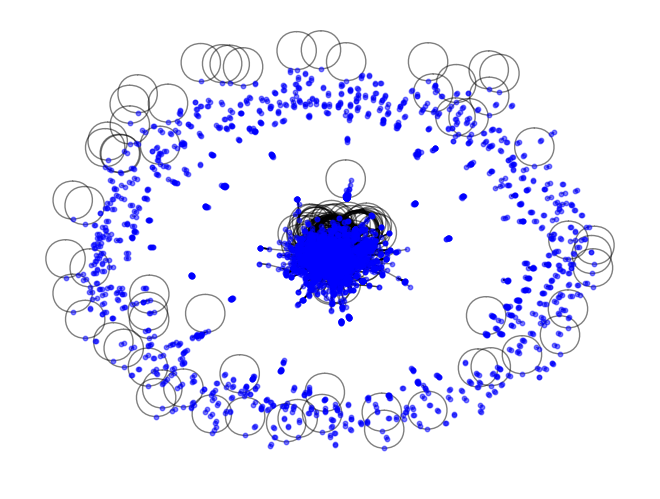

In [5]:

## 2)
G = nx.Graph()

hashtag_to_tweet_ids = {}

for index, row in df_filtered.iterrows():
    tweet_id = row["tweet_id"]
    hashtags = row["hashtags"]
    hashtags = hashtags.split()
    
    # For each hashtag, add the tweet_id to the list of tweet_ids associated with that hashtag
    for hashtag in hashtags:
        if hashtag not in hashtag_to_tweet_ids:
            hashtag_to_tweet_ids[hashtag] = []
        hashtag_to_tweet_ids[hashtag].append(tweet_id)

# Create edges between all tweet_ids that share the same hashtag
for hashtag, tweet_ids in hashtag_to_tweet_ids.items():
    # Create edges between all pairs of tweet_ids in the same hashtag group
    for i in range(len(tweet_ids)):
        for j in range(i+1, len(tweet_ids)):
            G.add_edge(tweet_ids[i], tweet_ids[j])

adj_matrix = nx.adjacency_matrix(G)


num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

connected_components = list(nx.connected_components(G))
# Calculate the average shortest path length for each component, because some parts are disconnected
avg_path_lengths = []
for component in connected_components:
    subgraph = G.subgraph(component)
    if len(subgraph) > 1:
        avg_path_lengths.append(nx.average_shortest_path_length(subgraph))

if avg_path_lengths:
    overall_avg_path_length = sum(avg_path_lengths) / len(avg_path_lengths)
    print(f"Average shortest path length across components: {overall_avg_path_length}")
else:
    print("No components with more than one node.")
degree_centrality = nx.degree_centrality(G)
avg_degree_centrality = sum(degree_centrality.values()) / num_nodes if num_nodes > 0 else 0
max_degree_centrality = max(degree_centrality.values()) if degree_centrality else 0
min_degree_centrality = min(degree_centrality.values()) if degree_centrality else 0
num_components = nx.number_connected_components(G)

print("Graph Metrics:")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average path length: {overall_avg_path_length}")
print(f"Max degree centrality: {max_degree_centrality}")
print(f"Min degree centrality: {min_degree_centrality}")
print(f"Avg degree centrality: {avg_degree_centrality}")
print(f"Number of components: {num_components}")

nx.draw(G, node_size=10, node_color="blue", alpha=0.5, with_labels=False)



In [6]:

# COO for easy data access
coo = adj_matrix.tocoo()

# Connect to a local SQLite file in the current directory (Create if not created already)
conn = sqlite3.connect("adjacency_matrix.db")
c = conn.cursor()

c.execute('''
CREATE TABLE IF NOT EXISTS edges (
    source INTEGER,
    target INTEGER,
    weight INTEGER
)
''')

# Prepare all nonzero entries as (row, col, data)
edges = list(zip(coo.row.tolist(), coo.col.tolist(), coo.data.tolist()))

# Insert data to database
c.executemany(
    'INSERT INTO edges (source, target, weight) VALUES (?, ?, ?)',
    edges
)
conn.commit()
conn.close()

print(f"Saved {len(edges)} edges into local file adjacency_matrix.db")


Saved 829869 edges into local file adjacency_matrix.db


Top 3 Largest Components:
Largest component size: 6661
Second largest component size: 64
Third largest component size: 19


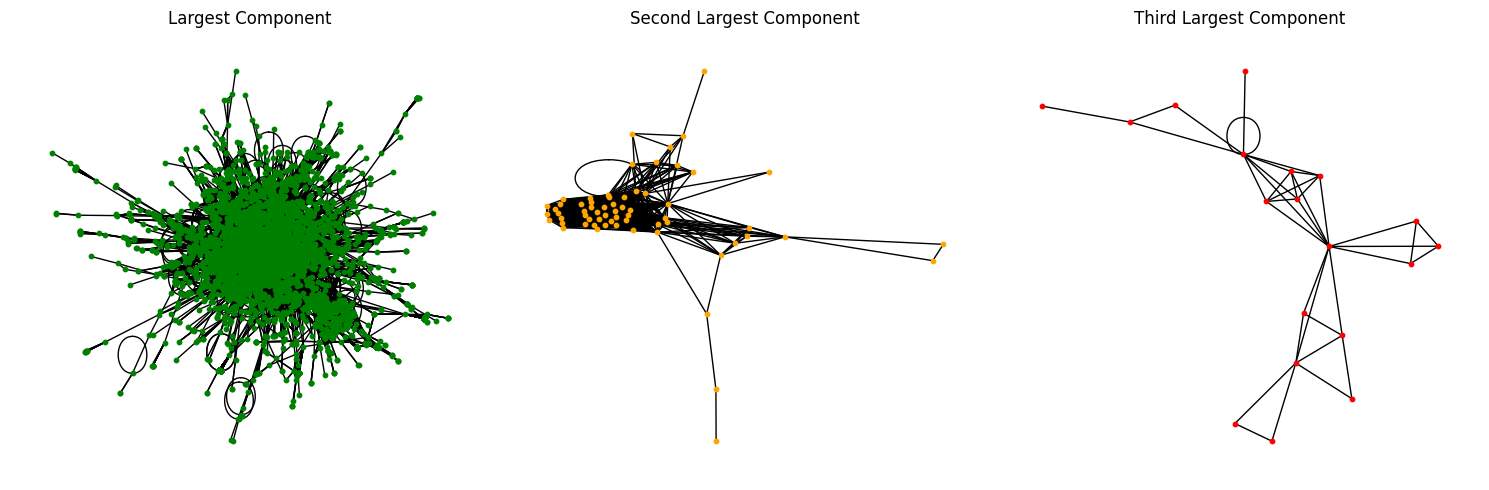

In [7]:

## 3)
connected_components = list(nx.connected_components(G))

# Sort components by size in descending order
sorted_components = sorted(connected_components, key=len, reverse=True)

# Extract the largest, second largest, and third largest components
largest_component = G.subgraph(sorted_components[0]).copy() if len(sorted_components) > 0 else None
second_largest_component = G.subgraph(sorted_components[1]).copy() if len(sorted_components) > 1 else None
third_largest_component = G.subgraph(sorted_components[2]).copy() if len(sorted_components) > 2 else None

print("Top 3 Largest Components:")
print(f"Largest component size: {largest_component.number_of_nodes() if largest_component else 0}")
print(f"Second largest component size: {second_largest_component.number_of_nodes() if second_largest_component else 0}")
print(f"Third largest component size: {third_largest_component.number_of_nodes() if third_largest_component else 0}")

plt.figure(figsize=(15, 5))

if largest_component:
    plt.subplot(1, 3, 1)
    nx.draw(largest_component, node_size=10, node_color="green", with_labels=False)
    plt.title("Largest Component")

if second_largest_component:
    plt.subplot(1, 3, 2)
    nx.draw(second_largest_component, node_size=10, node_color="orange", with_labels=False)
    plt.title("Second Largest Component")

if third_largest_component:
    plt.subplot(1, 3, 3)
    nx.draw(third_largest_component, node_size=10, node_color="red", with_labels=False)
    plt.title("Third Largest Component")

plt.tight_layout()
plt.show()


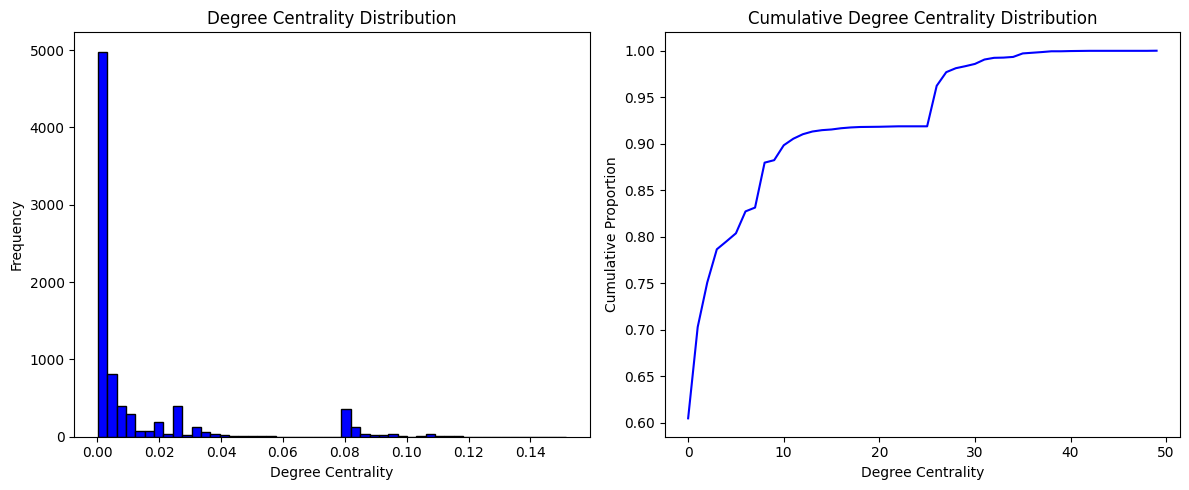

In [8]:
## 4)

# Compute degree centrality
degree_centrality = nx.degree_centrality(G)

# Get degree centrality values sorted
centrality_values = sorted(degree_centrality.values())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(centrality_values, bins=50, color="blue", edgecolor="black")
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")

cumulative = np.cumsum(np.histogram(centrality_values, bins=50)[0])
cumulative = cumulative / cumulative[-1]

plt.subplot(1, 2, 2)
plt.plot(cumulative, color="blue")
plt.title("Cumulative Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Cumulative Proportion")

plt.tight_layout()
plt.show()


C:\Users\Roni Karppinen\AppData\Roaming\Python\Python313\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


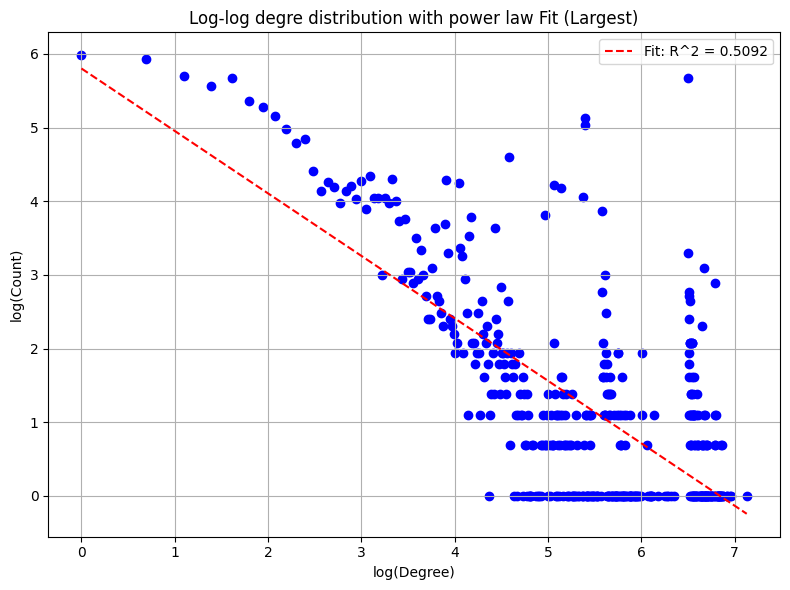

Largest Power law statistics:
  Power law α      = 18.8756
  Power law xmin   = 913.0
  R (vs lognormal) = -0.7508
  p-value          = 0.2534


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


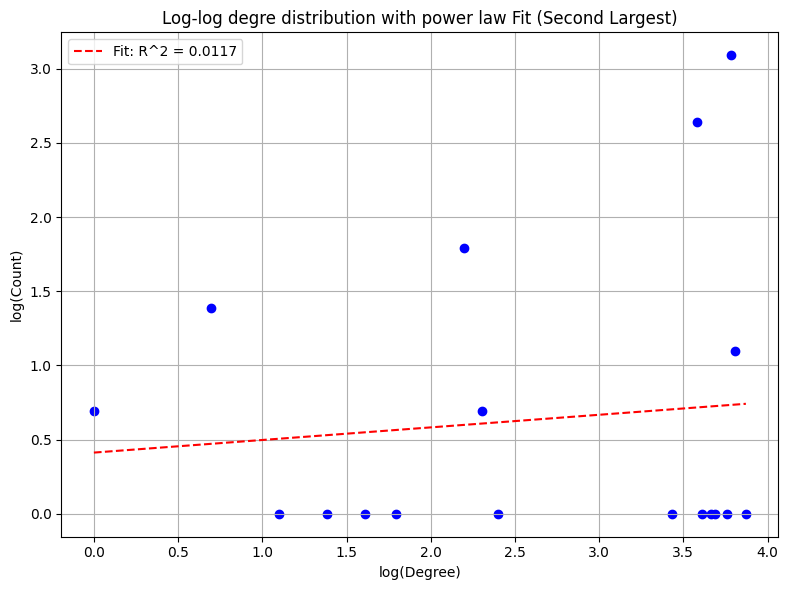

Second Largest Power law statistics:
  Power law α      = 169.3611
  Power law xmin   = 44.0
  R (vs lognormal) = -0.2096
  p-value          = 0.6203


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


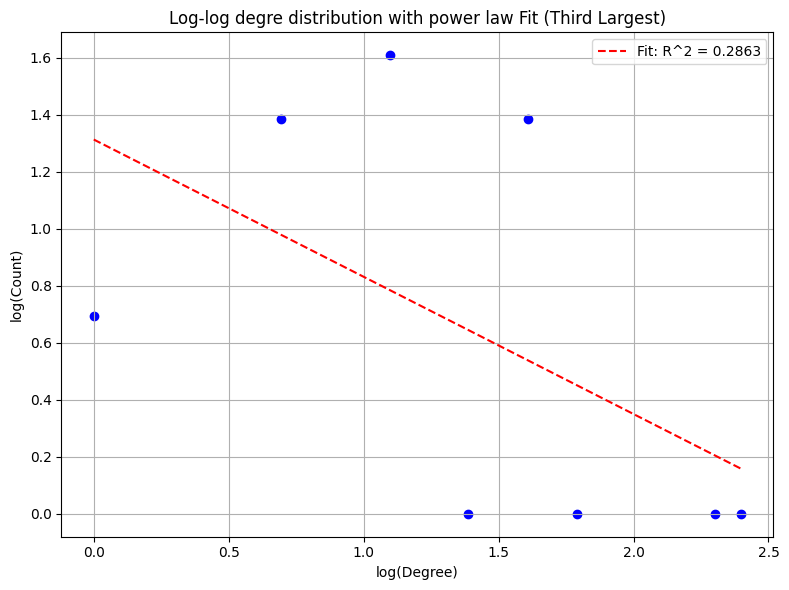

Third Largest Power law statistics:
  Power law α      = 5.2069
  Power law xmin   = 5.0
  R (vs lognormal) = -1.0091
  p-value          = 0.1012


In [9]:


components = {
    "Largest": largest_component,
    "Second Largest": second_largest_component,
    "Third Largest": third_largest_component
}

for name, comp in components.items():
    degrees = [d for _, d in comp.degree()]
    results = powerlaw.Fit(degrees, verbose=False)
    alpha = results.power_law.alpha
    xmin = results.power_law.xmin

    R, p = results.distribution_compare("power_law", "lognormal")
    degree_counts = np.bincount(degrees)
    degrees_nonzero = np.nonzero(degree_counts)[0]
    counts_nonzero = degree_counts[degrees_nonzero]

    log_degrees = np.log(degrees_nonzero)
    log_counts = np.log(counts_nonzero)

    slope, intercept, r_value, _, _ = linregress(log_degrees, log_counts)

    plt.figure(figsize=(8, 6))
    plt.scatter(log_degrees, log_counts, color="blue")
    plt.plot(log_degrees, intercept + slope * log_degrees, "r--", label=f"Fit: R^2 = {r_value**2:.4f}")
    plt.title(f"Log-log degre distribution with power law Fit ({name})")
    plt.xlabel("log(Degree)")
    plt.ylabel("log(Count)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"{name} Power law statistics:")
    print(f"  Power law α      = {alpha:.4f}")
    print(f"  Power law xmin   = {xmin}")
    print(f"  R (vs lognormal) = {R:.4f}")
    print(f"  p-value          = {p:.4f}")

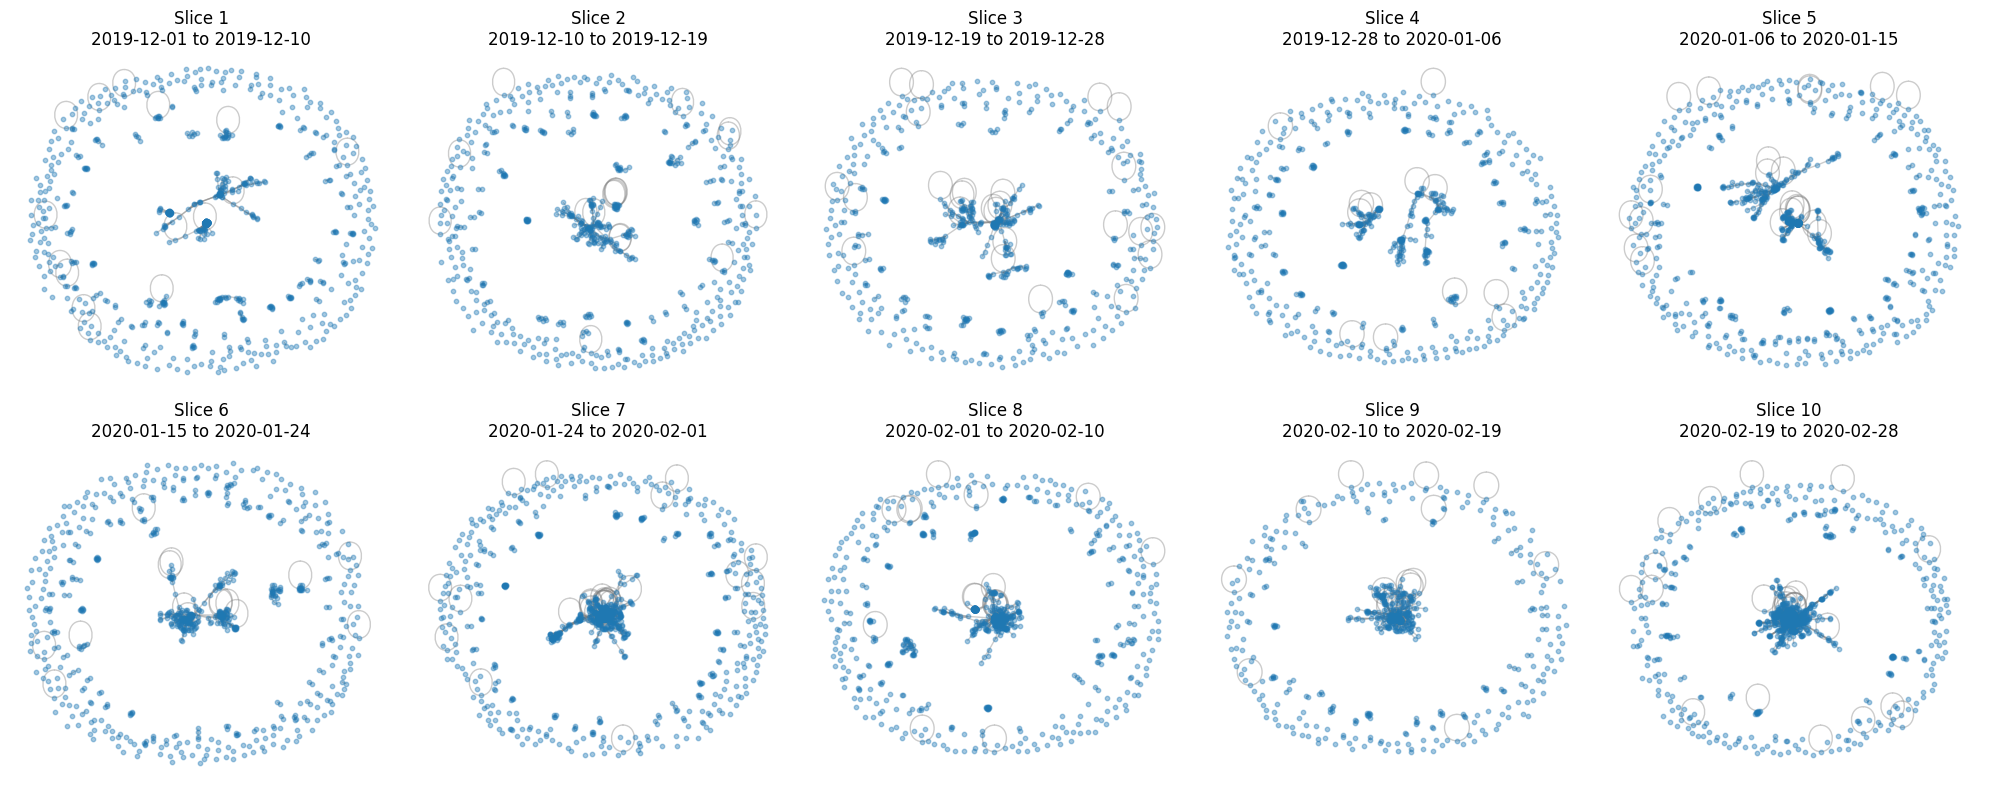

,interval,nodes,edges,avg_path_len,diameter
0,2019-12-01 to 2019-12-10,870,24140,1.257837,7
1,2019-12-10 to 2019-12-19,622,805,4.570755,12
2,2019-12-19 to 2019-12-28,579,1581,3.858648,10
3,2019-12-28 to 2020-01-06,576,1019,6.849691,17
4,2020-01-06 to 2020-01-15,916,24657,2.172452,8
5,2020-01-15 to 2020-01-24,717,1759,4.451231,12
6,2020-01-24 to 2020-02-01,1076,18300,3.279466,12
7,2020-02-01 to 2020-02-10,952,18322,3.300004,10
8,2020-02-10 to 2020-02-19,673,8480,3.005923,9
9,2020-02-19 to 2020-02-28,1257,39674,2.787230,10


In [10]:
start, end = df_filtered["timestamp"].min(), df_filtered["timestamp"].max()
# 10 interval
breaks = pd.date_range(start, end, periods=11)

stats = []

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(10):
    t0, t1 = breaks[i], breaks[i+1]
    # select tweets in timestamp 0 and timestam 1
    mask = (df_filtered["timestamp"] >= t0) & (df_filtered["timestamp"] < t1)
    tids = df_filtered.loc[mask, "tweet_id"].tolist()
    
    Gi = G.subgraph(tids).copy()
    n_nodes = Gi.number_of_nodes()
    n_edges = Gi.number_of_edges()
    
    # largest connected compoment
    lcc_nodes = max(nx.connected_components(Gi), key=len)
    G_lcc = Gi.subgraph(lcc_nodes)
    apl = nx.average_shortest_path_length(G_lcc)
    diam = nx.diameter(G_lcc)
    # collect stats
    stats.append({
        "interval": f"{t0.date()} to {t1.date()}",
        "nodes": n_nodes,
        "edges": n_edges,
        "avg_path_len": apl,
        "diameter": diam
    })
    ax = axes[i]

    nx.draw_spring(
        Gi,
        ax=ax,
        node_size=10,
        edge_color="gray",
        alpha=0.4,
        with_labels=False
    )
    ax.set_title(f"Slice {i+1}\n{t0.date()} to {t1.date()}")
    ax.axis("off")

plt.tight_layout()
plt.show()

summary_df = pd.DataFrame(stats)
summary_df.head(10)

[1535016, 1372, 11672, 2529, 1640704, 8770, 704206, 680712, 221316, 2322018]


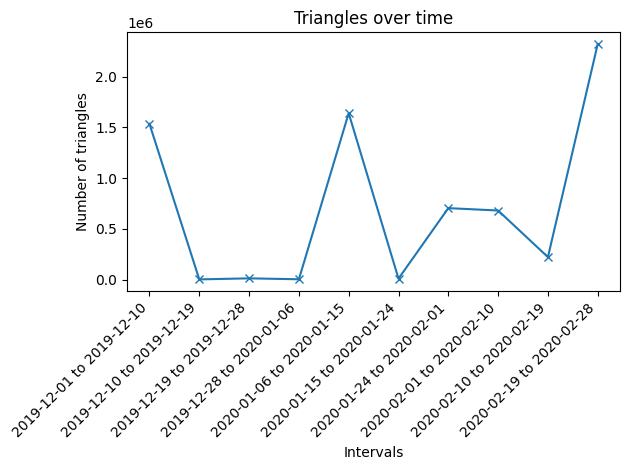

In [11]:
## 7)

triangle_counts = []
interval_labels = []

for i in range(10):
    t0, t1 = breaks[i], breaks[i+1]
    tids = df_filtered[(df_filtered["timestamp"] >= t0) & (df_filtered["timestamp"] < t1)]["tweet_id"]
    Gi = G.subgraph(tids).copy()
    
    # count tringles: sum of node triangles divided by 3 https://stackoverflow.com/questions/60426256/finding-total-number-of-triangles-using-networkx
    tri_dict = nx.triangles(Gi)
    total_triangles = sum(tri_dict.values()) // 3
    
    triangle_counts.append(total_triangles)
    interval_labels.append(f"{t0.date()} to {t1.date()}")
print(triangle_counts)
plt.figure()
plt.plot(range(1, 11), triangle_counts, marker="x")
plt.xticks(range(1, 11), interval_labels, rotation=45, ha="right")
plt.xlabel("Intervals")
plt.ylabel("Number of triangles")
plt.title("Triangles over time")
plt.tight_layout()
plt.show()

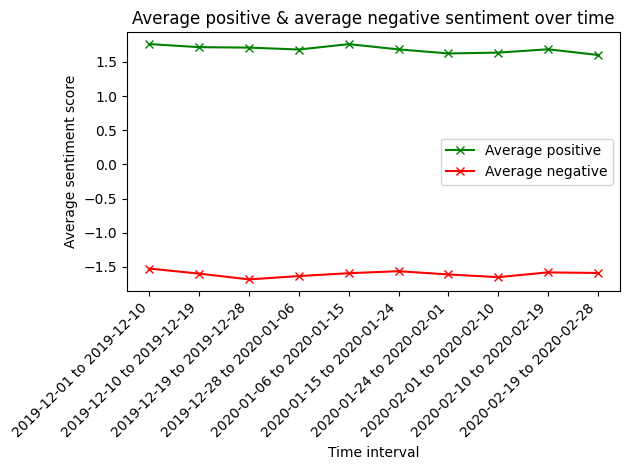

In [12]:
## 8)


sent_split = df_filtered["sentiment"].str.split()
df_filtered["sent_pos"] = sent_split.str.get(0).astype(int)
df_filtered["sent_neg"] = sent_split.str.get(1).astype(int)

avg_pos = []
avg_neg = []
interval_labels = []

for i in range(10):
    t0, t1 = breaks[i], breaks[i+1]
    mask = (df_filtered["timestamp"] >= t0) & (df_filtered["timestamp"] < t1)
    slice_df = df_filtered.loc[mask]
    
    # take the mean (NaN if no tweets in slice)
    avg_pos.append(slice_df["sent_pos"].mean())
    avg_neg.append(slice_df["sent_neg"].mean())
    interval_labels.append(f"{t0.date()} to {t1.date()}")


plt.figure()
plt.plot(range(1, 11), avg_pos, marker="x", color="green", label="Average positive")
plt.plot(range(1, 11), avg_neg, marker="x", color="red", label="Average negative")
plt.xticks(range(1, 11), interval_labels, rotation=45, ha="right")
plt.xlabel("Time interval")
plt.ylabel("Average sentiment score")
plt.title("Average positive & average negative sentiment over time")
plt.legend()
plt.tight_layout()
plt.show()

{'beta': 0.1, 'lambda': 0.72, 'tp_rate': 0.25}
β=0.1, λ=0.72: final infected = 34 / 870


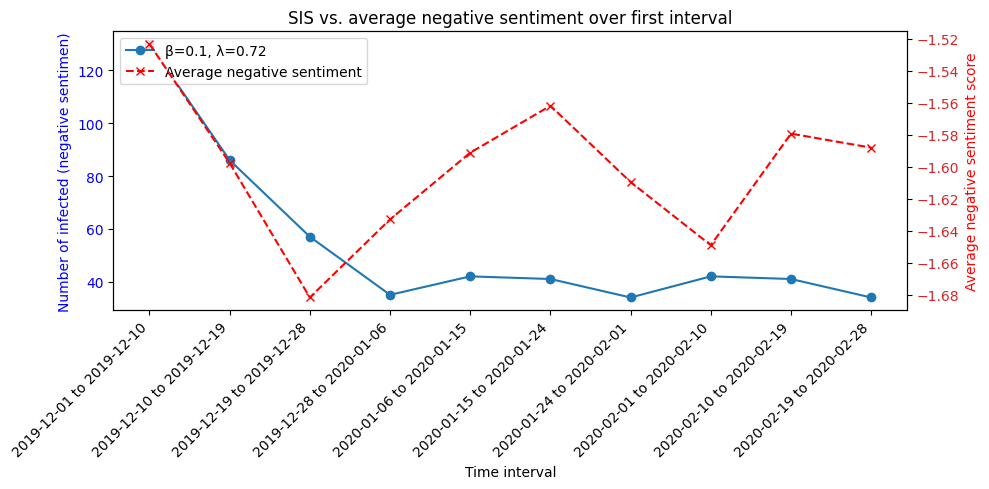

In [ ]:
## 9)

# reference https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIS.html

t0, t1 = breaks[0], breaks[1]
first_ids = df_filtered[(df_filtered["timestamp"] >= t0) & (df_filtered["timestamp"] < t1)]["tweet_id"]
G1 = G.subgraph(first_ids).copy()

model = ep.SISModel(G1, seed=10)
param_sets = [
    {"beta": 0.1, "lambda": 0.1, "tp_rate": 0.250},
]

fig, ax1 = plt.subplots(figsize=(10, 5))


for params in param_sets:
    print(params)
    cfg = Configuration()
    cfg.add_model_parameter("beta", params["beta"])
    cfg.add_model_parameter("lambda", params["lambda"])
    cfg.add_model_parameter("tp_rate", params["tp_rate"])
    cfg.add_model_parameter("percentage_infected", 0.15)
    model.set_initial_status(cfg)

    iteration = model.iteration_bunch(10)
    entry = model.build_trends(iteration)[0]
    infected_ts = entry["trends"]["node_count"][1]

    label = f"β={params["beta"]}, λ={params["lambda"]}"
    ax1.plot(
        range(1, 11),
        infected_ts,
        marker="o",
        label=label
    )
    print(f"{label}: final infected = {infected_ts[-1]} / {G1.number_of_nodes()}")

ax1.set_xlabel("Time interval")
ax1.set_ylabel("Number of infected (negative sentimen)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xticks(range(1, 11))
ax1.set_xticklabels(interval_labels, rotation=45, ha="right")

# plot avg_neg from 8)
ax2 = ax1.twinx()
ax2.plot(
    range(1, 11),
    avg_neg,
    marker="x",
    linestyle="--",
    color="red",
    label="Average negative sentiment"
)
ax2.set_ylabel("Average negative sentiment score", color="red")
ax2.tick_params(axis="y", labelcolor="tab:red")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.title("SIS vs. average negative sentiment over first interval")
plt.tight_layout()
plt.show()